In [13]:
import astropy
from astropy.io import fits
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import odr
from matplotlib.pyplot import figure

In [14]:
#APOKASC file & file variables
hdul = fits.open(r"/Users/amber3/Desktop/SSI/APOKASC_cat_v6.7.2.fits")
hdu = hdul[1]
A_data = hdu.data
#print(np.size(A_data))
KIC_A = hdu.data['KEPLER_INT'] 
Logg_A = hdu.data['DR16_LOGG_COR']
Teff_A = hdu.data['DR16_TEFF_COR']
FeH_A = hdu.data['DR16_M_H_COR']
R_APO3 = hdu.data['APOKASC3P_RADIUS']

In [15]:
#GAIA file variables
#there are some empty entries in error and radius, so flags are put in as -42 and only pos entries are taken
G_data = ascii.read('/Users/amber3/Desktop/gaia_radii_apokasc3 .dat', delimiter = ',') #data_Splitter = 'KIC') #fill_values = [('-42.0', '', '-42.0')])
KIC_G = G_data['KIC']
R_G = 1.0/G_data['inv_r_gaia_K_MIST']
R_G_err_per = G_data['inv_r_gaia_K_MIST_err']/G_data['inv_r_gaia_K_MIST'] 
R_G_err = R_G_err_per * R_G

In [16]:
#APOLLINAIRE file & file variables (b = background)
hdul_b = fits.open(r"/Users/amber3/Desktop/SSI/Selected_stars_final.fits")
hdu_b = hdul_b[0]
B_data = hdu_b.data
KIC_B = np.array(B_data[:,0,0])

In [17]:
#Intersection between Apollinaire and APOKASC
common_KIC, A_indices, B_indices = np.intersect1d(KIC_A, KIC_B, return_indices=True)

good_indices = np.where((Teff_A[A_indices] > 0) & (R_APO3[A_indices] > 0))
bad_indices = np.where(np.logical_or(Teff_A[A_indices] <= 0, R_APO3[A_indices] <= 0))

B_indices = B_indices[good_indices]
A_indices = A_indices[good_indices]

A_data = A_data[A_indices]
B_data = np.array(B_data[B_indices,:,:])

KIC_B = np.array(B_data[:,0,0])

In [18]:
#intersection between Gaia and (Apollinaire & Apokasc)
common_KIC_G, G_indices, AB_indices = np.intersect1d(KIC_G, KIC_B, return_indices=True)
good_indices = np.where((R_G[G_indices] > 0) & (R_G_err[G_indices] > 0))
G_indices = G_indices[good_indices]
AB_indices = AB_indices[good_indices]

G_data = G_data[G_indices]
A_data = A_data[AB_indices]
B_data = B_data[AB_indices]

In [19]:
#Raw data Variables
ln10 = np.log(10)
Teff = A_data['DR16_TEFF_COR']
logTeff = np.log10(Teff)
elogTeff = A_data['DR16_TEFF_COR_ERR']/Teff/ln10
logg = A_data['DR16_LOGG_COR']
elogg = A_data['DR16_LOGG_COR_ERR']
FeH = A_data['DR16_M_H_COR']
eFeH = A_data['Dr16_M_H_COR_ERR']
logAmp1 = np.log10(B_data[:,0,6])
elogAmp1 = B_data[:,1,6]/B_data[:,0,6]/ln10
logAmp2 = np.log10(B_data[:,0,9])
elogAmp2 = B_data[:,1,9]/B_data[:,0,9]/ln10
logFreq1 = np.log10(B_data[:,0,7])
elogFreq1 = B_data[:,1,7]/B_data[:,0,7]/ln10
logFreq2 = np.log10(B_data[:,0,10])
elogFreq2 = B_data[:,1,10]/B_data[:,0,10]/ln10
Evolstage = B_data[:,0,3]
iRG = np.where(Evolstage == 1)
iRC = np.where(Evolstage == 2)
iRGs = ()
iRCs = ()
logR_G = -np.log10(G_data['inv_r_gaia_K_MIST'])
elogR_G = G_data['inv_r_gaia_K_MIST_err']/G_data['inv_r_gaia_K_MIST']/ln10
logR_A = A_data['APOKASC3P_RADIUS'] #check
elogR_A = A_data['APOKASC3P_RADIUS_ERR'] #check
rpw = 2

In [20]:
def linear_fit(X,a,b,c,d):
    x,y,z = X
    return a+b*x+c*y+z*d

In [21]:
#General function for orthogonal fitting of amps and freqs
def odr_fit(A, X):
    x,y,z = X
    return A[0]+A[1]*x+A[2]*y+A[3]*z

In [22]:
def orth_fittings(x,sx,y,sy):
    c_data = odr.RealData(x, y, sx=sx, sy=sy)
    linear = odr.Model(odr_fit)
    beta0 = [183.7, -48.0, -0.73, -0.52] #softcode first linear guesses based j in loop
    c_odr = odr.ODR(c_data, linear, beta0=beta0)
    c_output = c_odr.run()
    #c_output.pprint()
    print(c_output.beta)
    return c_output

In [42]:
#coeffs and errors are 4x2x4 arrays (input)
def plottings(coeffs,errors):
    %matplotlib inline
    figure(figsize=(8,8), dpi=100)
    minimum = np.amin(coeffs-errors)
    maximum = np.amax(coeffs+errors)
    margin = (maximum - minimum)*0.03
    x = [0, 1, 2, 3]
    #coeffs = np.ones([4,6,2])
    #ecoeffs = np.ones([4,6,2])
    xl = 0.70
    dxl = 0.15
#arrays of lines so it depends on dimensions of coeffs ? look for next time
#IDEAS: there's update_datalim or just initialize array and specify data[] to add in handles
    labels = ['f1', 'f2', 'A1', 'A2']
    style = ['solid', 'dashed']
    titl = ['red giants', 'red clump']
    line = {}
    for j in range(0,2): #(only using r corrected amps), j is rgb=0 or redclump=1
        for k in range(0,4): #k is Harvey params of two components. 0=A1, 1=f1, 2=A2, 3=f2
            line[j,k] = plt.errorbar(x, coeffs[:,j,k], yerr = errors[:,j,k], capsize = 4, linestyle = style[j], label = labels)
        leg = plt.legend(handles=[np.reshape(line[j,:], [4])], title = titl[j], loc = (xl,0.1))
        plt.gca().add_artist(leg)
        return line
        #else: 
            #line[j,k] = plt.errorbar(x, np.reshape(coeffs[]), yerr = np.reshape(), capsize = 4, linestyle = 'dashed', label = labels)
            #leg_giant = plt.legend(handles=[line], title = 'red clump', loc = (xl,0.1))
            #plt.gca().add_artist(leg_giant)
    
    plt.ylim(minimum - margin, maximum + margin)
    plt.xticks([0, 1, 2, 3], ['const', 'log(Teff)', 'logg', '[Fe/H]'])
    plt.ylabel('Fitting Coefficients')
    plt.show()

In [43]:
NH = 4 #number of Harvery comps
Nj = 4 #j samples of stars: either all red giants, all red clump, subsamples, etc
Np = 3 + 1 #number of atm params plus offset
c = np.ndarray((NH,Nj,Np), dtype=float)
e = c

for j in (0,1,2,3):
    if j < 4:
        #Use Gaia Radii
        logAmp1_R = logAmp1 + rpw * logR_G 
        elogAmp1_R = np.sqrt(elogAmp1**2 + (rpw*elogR_G)**2)
    else:
        #Use APO3 Radii
        logAmp1_R = logAmp1 + rpw * logR_A #change tp APO3 Radii variables
        elogAmp1_R = np.sqrt(elogAmp1**2 + (rpw*elogR_A)**2)
    if j == 0: #all red giants
        ii = iRG
        print('Giants_Gaia')
    elif j == 1: #all red clump
        ii = iRC
        print('Red_Clump_Gaia')
    #elif j == 2: #matched subsample giants
        #ii = iRGs
        #for i in range(0, np.size(iRG)):
            #dist = np.sqrt((7*()))
    #elif j== 3: #matched subsample clump
        #ii = iRCs
    else:
        print('how did we get here??')
    x = [logTeff[ii], logg[ii], FeH[ii]]
    sx = [elogTeff[ii], elogg[ii], eFeH[ii]]
    
    y = [logAmp1[ii]]
    sy = [elogAmp1[ii]]
    print('A1_fit:')
    A1_fit = orth_fittings(x,sx,y,sy)
    c[0,j,:] = A1_fit.beta
    e[0,j,:] = A1_fit.sd_beta
    
    y = [logFreq1[ii]]
    sy = [elogFreq1[ii]]
    print('f1_fit:')
    f1_fit = orth_fittings(x,sx,y,sy)
    c[1,j,:] = f1_fit.beta
    e[1,j,:] = f1_fit.sd_beta
    
    y = [logAmp2[ii]]
    sy = [elogAmp2[ii]]
    print('A2_fit:')
    A2_fit = orth_fittings(x,sx,y,sy)
    c[2,j,:] = A2_fit.beta
    e[2,j,:] = A2_fit.sd_beta
    
    y = [logFreq2[ii]]
    sy = [elogFreq2[ii]]
    print('f2_fit:')
    f2_fit = orth_fittings(x,sx,y,sy)
    c[3,j,:] = f2_fit.beta
    e[3,j,:] = f2_fit.sd_beta


Giants_Gaia
A1_fit:
[ 369.95964338 -101.55594751    2.53099205   -1.95686022]
f1_fit:
[ 648.40179735 -182.78328117    9.01718293   -3.81443906]
A2_fit:
[ 473.39099771 -130.75651543    3.70859076   -2.56825606]
f2_fit:
[ 540.59767091 -152.32244583    7.68572835   -3.19539174]
Red_Clump_Gaia
A1_fit:
[182.67908575 -49.40432938   1.33364213  -1.98953653]
f1_fit:
[-92.5283185   26.1938668   -1.15668919   1.09529983]
A2_fit:
[208.29619082 -56.78685999   1.70215799  -2.40282688]
f2_fit:
[-67.35486573  19.11958133  -0.5998097    0.8154046 ]
how did we get here??
A1_fit:
[182.67908575 -49.40432938   1.33364213  -1.98953653]
f1_fit:
[-92.5283185   26.1938668   -1.15668919   1.09529983]
A2_fit:
[208.29619082 -56.78685999   1.70215799  -2.40282688]
f2_fit:
[-67.35486573  19.11958133  -0.5998097    0.8154046 ]
how did we get here??
A1_fit:
[182.67908575 -49.40432938   1.33364213  -1.98953653]
f1_fit:
[-92.5283185   26.1938668   -1.15668919   1.09529983]
A2_fit:
[208.29619082 -56.78685999   1.702157

(4, 2, 4)


TypeError: unhashable type: 'slice'

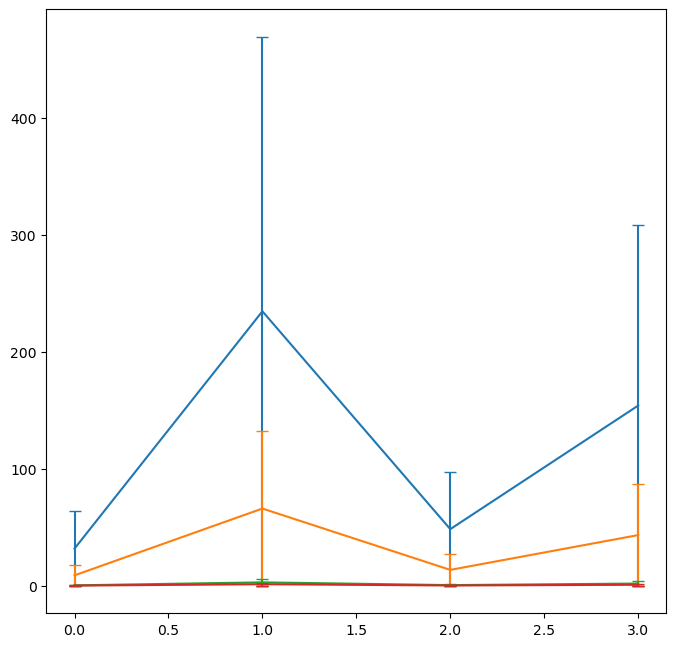

In [44]:
#call plottings with 4 subplots here 
#reshape arrays here
#two plots with whole sample, Gaia and APO3
#two plots with subsample, Gaia and APO3
#choose which radius we're using for each plot here?
#add titles here also
#add overplotting variable so we can change between two different radii, or full and matched subsamples, etc

print(np.shape(c[:,0:2,:]))
line = plottings(np.reshape(c[:,0:2,:],[4,2,4]),np.reshape(e[:,0:2,:],[4,2,4])) #4x2x4 array input

In [ ]:
#google err message
#print shape of reshaped line and line slice we want